<a href="https://colab.research.google.com/github/rahulyad011/intrusion-detection/blob/main/NIDS1_CICIDS_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model
import pickle # saving and loading trained model
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importing library for support vector machine classifier
from sklearn.svm import SVC

# MLP requirements 
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

# LSTM requirements 
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

# evaluation metrices
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# representation of model layers
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bin_data_total = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nids_project_data/cicids2017_data/bin_data_processed.csv")
bin_data_total.drop(bin_data_total.columns[0],axis=1,inplace=True)
bin_data_total

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,binary_label
0,80,3751908,5,0,30,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,80,83406801,5,7,303,11595,291,0,60.600000,128.832449,...,20,7022.0,0.0,7022,7022,83200000.0,0.0,83200000,83200000,0
2,80,2,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
3,80,97900308,8,5,56,11607,20,0,7.000000,5.656854,...,20,4142902.0,0.0,4142902,4142902,93100000.0,0.0,93100000,93100000,0
4,22,10914142,21,32,2008,2745,640,0,95.619048,140.045163,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566143,49362,209,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1
566144,53,582,1,1,54,119,54,54,54.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1
566145,53,50488,1,1,54,82,54,54,54.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
566146,53,90851,4,2,140,254,35,35,35.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1


In [4]:
# distribution of label class before sampling
data_size = bin_data_total.shape[0]
# data_size
bin_data_total.binary_label.value_counts()/data_size

1    0.803004
0    0.196996
Name: binary_label, dtype: float64

In [5]:
# numeric feature normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

numeric_cols = bin_data_total.select_dtypes(['number']).columns
numeric_cols = numeric_cols.drop('binary_label')
flag = 0
scaler = None
if flag:
  # using standard scaler for normalizing
  scaler = StandardScaler()
else:
  # using minmax scaler for normalizing
  # to avoid negative values after scaling
  scaler = MinMaxScaler()

def normalization_train(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.fit_transform(arr.reshape(len(arr),1))
  return df

def normalization_test(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.transform(arr.reshape(len(arr),1))
  return df

# numeric_cols

In [6]:
# sampling data taking only 20% of the data
bin_data = bin_data_total.groupby('binary_label', group_keys=False).apply(lambda x: x.sample(frac=0.5))
bin_data

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,binary_label
69077,3809,47,1,1,0,6,0,0,0.000,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,0
57887,80,98129114,8,7,355,11595,349,0,44.375,123.104993,...,20,1007.0,0.0,1007,1007,98100000.0,0.0,98100000,98100000,0
27158,80,11768851,4,0,24,0,6,6,6.000,0.000000,...,20,49.0,0.0,49,49,11800000.0,0.0,11800000,11800000,0
32126,80,5593510,5,0,30,0,6,6,6.000,0.000000,...,20,1966.0,0.0,1966,1966,5591544.0,0.0,5591544,5591544,0
38922,80,4,2,0,0,0,0,0,0.000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424620,49743,71365,3,1,18,6,6,6,6.000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1
449802,443,1,2,0,12,0,6,6,6.000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,1
439012,1060,55,2,2,4,12,2,2,2.000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,1
269401,49161,3,2,0,4,0,2,2,2.000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,1


In [7]:
# distribution of label class after sampling
data_size = bin_data.shape[0]
bin_data.binary_label.value_counts()/data_size

1    0.803006
0    0.196994
Name: binary_label, dtype: float64

In [8]:
model_selection = {
    0 : "ALL",
    2 : "MLP",
    3 : "LSTM",
    4 : "AE"
}
model_flag = 0
svm_enable = 0

In [9]:
X = bin_data.iloc[:,0:78] # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = bin_data['binary_label'] # target attribute

In [10]:
# splitting the dataset 75% for training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42) 

In [11]:
# calling the normalization() function
X_train = normalization_train(X_train,numeric_cols)
X_train.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
58315,0.001221,0.001578,0.000011,0.000021,0.000028,1.851196e-05,0.000856,0.000000,0.001691,0.001771,...,0.000013,0.999999,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000
491867,0.000809,0.000002,0.000006,0.000008,0.000142,6.156300e-07,0.002783,0.031477,0.012684,0.000000,...,0.000007,0.999999,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000
136893,0.000809,0.001655,0.000006,0.000008,0.000089,1.818182e-07,0.001755,0.019855,0.008001,0.000000,...,0.000007,0.999999,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000
25962,0.001221,0.821706,0.000033,0.000025,0.000437,1.849282e-05,0.017166,0.000000,0.011179,0.026147,...,0.000007,0.999999,4.424779e-08,0.0,2.219756e-08,4.444444e-08,0.821667,0.0,0.821667,0.821667
393484,0.001221,0.050815,0.000011,0.000004,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.999999,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000


In [12]:
# calling the normalization() function
X_test = normalization_test(X_test,numeric_cols)
X_test.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
447447,8.658333e-06,4.083333e-07,1.666667e-08,0.000000e+00,3.333333e-08,0.000000e+00,1.666667e-08,1.666667e-08,1.666667e-08,0.000000e+00,...,8.333333e-09,2.000000e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464721,4.416667e-07,1.458333e-06,1.666667e-08,1.666667e-08,5.333333e-07,8.000000e-07,2.666667e-07,2.666667e-07,2.666667e-07,0.000000e+00,...,8.333333e-09,2.666667e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225405,4.416667e-07,1.658333e-06,1.666667e-08,1.666667e-08,5.500000e-07,8.166667e-07,2.750000e-07,2.750000e-07,2.750000e-07,0.000000e+00,...,8.333333e-09,1.666667e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1529,4.096417e-04,3.583333e-07,8.333333e-09,8.333333e-09,0.000000e+00,5.000000e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,3.333333e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418789,9.575833e-05,3.333333e-08,2.500000e-08,0.000000e+00,2.583333e-07,0.000000e+00,2.583333e-07,0.000000e+00,8.611111e-08,1.491488e-07,...,8.333333e-09,1.666667e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Linear Support Vector Machine Classifier (Binary Classification) **
to enable make the svm_enable = 1 in the above cell

In [13]:
if svm_enable:
  # using kernel as linear 
  lsvm = SVC(kernel='linear',gamma='auto') 
  lsvm.fit(X_train,y_train) # training model on training dataset

In [14]:
if svm_enable:
  pkl_filename = "/content/drive/MyDrive/Colab_Notebooks/Models/lsvm_binary_cicids2017.pkl"
  if (not path.isfile(pkl_filename)):
    # saving the trained model to disk
    with open(pkl_filename, 'wb') as file:
      pickle.dump(lsvm, file)
    print("Saved model to disk")
    # loading the trained model from disk
    with open(pkl_filename, 'rb') as file:
      lsvm = pickle.load(file)
    print("Loaded model from disk") 

In [15]:
if svm_enable:
  y_pred = lsvm.predict(X_test) # predicting target attribute on testing dataset
  ac = accuracy_score(y_test, y_pred)*100 # calculating accuracy of predicted data
  print("LSVM-Classifier Binary Set-Accuracy is ", ac)

In [16]:
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_classification
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=0)
# cm = confusion_matrix(y_test, y_pred, labels=lsvm.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=lsvm.classes_)
# disp.plot()

# plt.show()

In [17]:
if svm_enable:
  plt.figure(figsize=(20,8))
  plt.plot(y_pred[300:500], label="prediction", linewidth=2.0,color='blue')
  plt.plot(y_test[300:500].values, label="real_values", linewidth=2.0,color='lightcoral')
  plt.legend(loc="best")
  plt.ylim((-1,2))
  plt.title("Linear SVM Binary Classification")
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lsvm_real_pred_bin.png')
  plt.show()

In [18]:
if svm_enable:
  target_names = ['class 0', 'class 1']
  print(classification_report(y_test, y_pred, target_names=target_names))

In [19]:
if svm_enable:
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  clf = lsvm
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()

  plt.show()

## **Multi Layer Perceptron Classifier (Binary Classification)**

In [20]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  mlp = Sequential() # creating model

  # adding input layer and first layer with 50 neurons
  mlp.add(Dense(units=50, input_dim=X_train.shape[1], activation='relu'))
  # output layer with sigmoid activation
  mlp.add(Dense(units=1,activation='sigmoid'))

In [21]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # defining loss function, optimizer, metrics and then compiling model
  mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # summary of model layers
  mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3950      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
_________________________________________________________________


In [23]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # training the model on training dataset
  history = mlp.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
34/34 [==============================] - 2s 23ms/step - loss: 0.5343 - accuracy: 0.8298 - val_loss: 0.4319 - val_accuracy: 0.8752
Epoch 2/100
34/34 [==============================] - 0s 15ms/step - loss: 0.3932 - accuracy: 0.8781 - val_loss: 0.3602 - val_accuracy: 0.8858
Epoch 3/100
34/34 [==============================] - 1s 16ms/step - loss: 0.3463 - accuracy: 0.8856 - val_loss: 0.3290 - val_accuracy: 0.8879
Epoch 4/100
34/34 [==============================] - 1s 17ms/step - loss: 0.3188 - accuracy: 0.8865 - val_loss: 0.3045 - val_accuracy: 0.8881
Epoch 5/100
34/34 [==============================] - 1s 16ms/step - loss: 0.2944 - accuracy: 0.8867 - val_loss: 0.2807 - val_accuracy: 0.8881
Epoch 6/100
34/34 [==============================] - 1s 16ms/step - loss: 0.2717 - accuracy: 0.8868 - val_loss: 0.2599 - val_accuracy: 0.8882
Epoch 7/100
34/34 [==============================] - 1s 24ms/step - loss: 0.2520 - accuracy: 0.8869 - val_loss: 0.2422 - val_accuracy: 0.8877
Epoch 

In [24]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/mlp_binary.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/mlp_binary.h5'
  if (not path.isfile(filepath)):
    # serialize model to JSON
    mlp_json = mlp.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(mlp_json)

    # serialize weights to HDF5
    mlp.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    mlp = model_from_json(loaded_model_json)

    # load weights into new model
    mlp.load_weights(weightspath)
    print("Loaded model from disk")

In [25]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # defining loss function, optimizer, metrics and then compiling model
  mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # predicting target attribute on testing dataset
  test_results = mlp.evaluate(X_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}')

2212/2212 [==============================] - 4s 2ms/step - loss: 0.5092 - accuracy: 0.8042
Test results - Loss: 0.5092426538467407 - Accuracy: 80.4193913936615


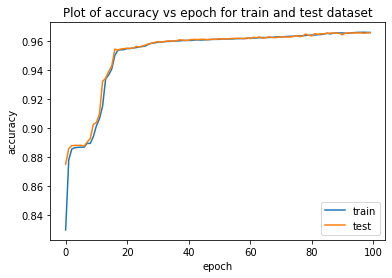

In [27]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":  
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_accuracy.png')
  plt.show()

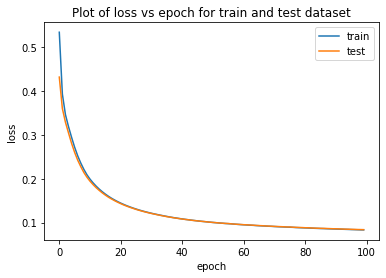

In [28]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Plot of loss vs epoch for train and test dataset')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_loss.png')
  plt.show()

In [29]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # representation of model layers
  from keras.utils.vis_utils import plot_model
  plot_model(mlp, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary.png', show_shapes=True,)

In [30]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  y_pred = mlp.predict(X_test).ravel()
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  auc = auc(fpr, tpr)

2212/2212 [==============================] - 4s 2ms/step


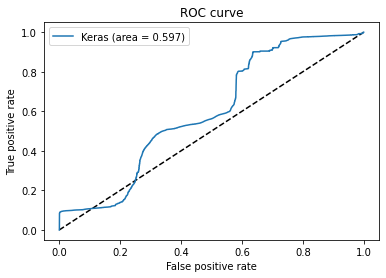

In [31]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_roc.png')
  plt.show()

In [32]:
# real_data_kdd = bin_data.copy()

# # Names of the columns that are discrete
# cat_cols = real_data_kdd.select_dtypes(['object']).columns
# # cat_cols
# test_data = real_data_kdd.iloc[:999]

# corr= test_data.corr()
# corr_y = abs(corr['binary_label'])
# highest_corr = corr_y
# highest_corr.sort_values(ascending=True)

In [33]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  y_classes = (mlp.predict(X_test)>0.5).astype('int32')

2212/2212 [==============================] - 7s 3ms/step


In [34]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))

Recall Score -  0.984218026989461
F1 Score -  0.8897937758973095
Precision Score -  0.8119013062409289


In [ ]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()

# **Correlation** Matrix of Features

In [35]:
corr= bin_data.corr()
corr_y = abs(corr['binary_label'])
highest_corr = corr_y[corr_y >0.3]
highest_corr.sort_values(ascending=True)

min_packet_length         0.316346
flow_iat_std              0.331296
idle_min                  0.376361
fwd_iat_max               0.384519
flow_iat_max              0.384662
idle_mean                 0.386310
idle_max                  0.390092
average_packet_size       0.415772
packet_length_mean        0.416661
fwd_iat_std               0.420072
packet_length_variance    0.454557
max_packet_length         0.455605
packet_length_std         0.471418
avg_bwd_segment_size      0.485488
bwd_packet_length_mean    0.485488
bwd_packet_length_max     0.493402
bwd_packet_length_std     0.511428
binary_label              1.000000
Name: binary_label, dtype: float64

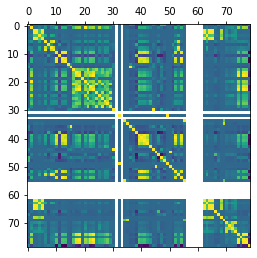

In [94]:
plt.matshow(corr)
plt.show()

## **LSTM Classifier**

In [36]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# y_train.shape   #(18896,)
X_train.shape

(212305, 78)

In [37]:
y_train = np.array(y_train)
type(y_train)

numpy.ndarray

In [38]:
x_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
x_train.shape

(212305, 1, 78)

In [39]:
x_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
x_test.shape

(70769, 1, 78)

In [40]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  lst = Sequential()
  # input layer and LSTM layer with 50 neurons
  input_features = x_train.shape[2]
  lst.add(LSTM(50,input_dim=input_features))

  # outpute layer with sigmoid activation
  lst.add(Dense(1,activation='sigmoid'))

In [41]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # defining loss function, optimizer, metrics and then compiling model
  lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [42]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # summary of model layers
  lst.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                25800     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 25,851
Trainable params: 25,851
Non-trainable params: 0
_________________________________________________________________


In [43]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # training the model on training dataset
  history = lst.fit(x_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
34/34 [==============================] - 6s 78ms/step - loss: 0.5893 - accuracy: 0.8062 - val_loss: 0.5034 - val_accuracy: 0.8316
Epoch 2/100
34/34 [==============================] - 1s 42ms/step - loss: 0.4471 - accuracy: 0.8575 - val_loss: 0.3983 - val_accuracy: 0.8679
Epoch 3/100
34/34 [==============================] - 1s 42ms/step - loss: 0.3767 - accuracy: 0.8724 - val_loss: 0.3550 - val_accuracy: 0.8789
Epoch 4/100
34/34 [==============================] - 1s 43ms/step - loss: 0.3451 - accuracy: 0.8838 - val_loss: 0.3310 - val_accuracy: 0.8882
Epoch 5/100
34/34 [==============================] - 1s 42ms/step - loss: 0.3239 - accuracy: 0.8864 - val_loss: 0.3122 - val_accuracy: 0.8880
Epoch 6/100
34/34 [==============================] - 1s 42ms/step - loss: 0.3056 - accuracy: 0.8863 - val_loss: 0.2945 - val_accuracy: 0.8879
Epoch 7/100
34/34 [==============================] - 2s 58ms/step - loss: 0.2877 - accuracy: 0.8864 - val_loss: 0.2769 - val_accuracy: 0.8882
Epoch 

In [44]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/lst_binary_cicids.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/lst_binary_cicids.h5'
  if (not path.isfile(filepath)):
    # serialize model to JSON
    lst_json = lst.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(lst_json)

    # serialize weights to HDF5
    lst.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    lst = model_from_json(loaded_model_json)

    # load weights into new model
    lst.load_weights(weightspath)
    print("Loaded model from disk")

In [45]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # load json and create model
  json_file = open(filepath, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  lst = model_from_json(loaded_model_json)

  # load weights into new model
  lst.load_weights(weightspath)
  print("Loaded model from disk")

Loaded model from disk


In [46]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # defining loss function, optimizer, metrics and then compiling model
  lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [47]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # predicting target attribute on testing dataset
  test_results = lst.evaluate(x_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2212/2212 [==============================] - 5s 2ms/step - loss: 0.4740 - accuracy: 0.8110
Test results - Loss: 0.4740010201931 - Accuracy: 81.09765648841858%


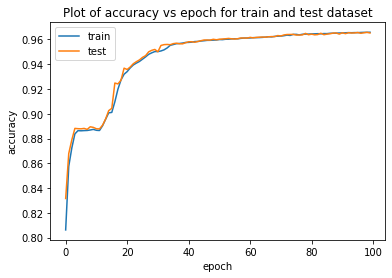

In [48]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary_accuracy.png')
  plt.show()

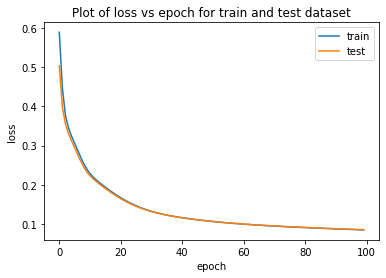

In [49]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary_loss.png')
  plt.show()

In [50]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # representation of model layers
  plot_model(lst, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary.png', show_shapes=True,)

In [51]:
y_test = np.array(y_test)
y_test.shape

(70769,)

In [52]:
type(y_test)

numpy.ndarray

In [53]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  y_classes = (lst.predict(x_test)>0.5).astype('int32')

2212/2212 [==============================] - 5s 2ms/step


In [54]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))

Recall Score -  0.9972201206960255
F1 Score -  0.8944490472245236
Precision Score -  0.8108815702881341


              precision    recall  f1-score   support

           0       0.45      0.37      0.41     13932
           1       0.85      0.89      0.87     56837

    accuracy                           0.79     70769
   macro avg       0.65      0.63      0.64     70769
weighted avg       0.77      0.79      0.78     70769



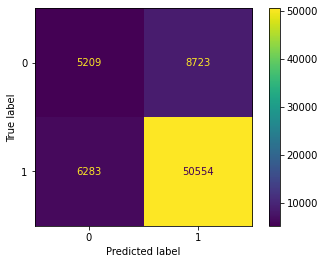

In [93]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()

## **Auto Encoder**

In [55]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # splitting the dataset 75% for training and 25% testing
  X_train, X_test = train_test_split(bin_data, test_size=0.25, random_state=42)

In [56]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # dataset excluding target attribute (encoded, one-hot-encoded,original)
  X_train = X_train.drop(['binary_label'],axis=1) 

  y_test = X_test['binary_label'] # target attribute

  # dataset excluding target attribute (encoded, one-hot-encoded,original)
  X_test = X_test.drop(['binary_label'],axis=1)
  # calling the normalization() function
  X_train = normalization_train(X_train,numeric_cols)
  X_test = normalization_test(X_test,numeric_cols)
  X_train = X_train.values
  X_test = X_test.values
  y_test = y_test.values

In [57]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  input_dim = X_train.shape[1]
  encoding_dim = 50

  #input layer
  input_layer = Input(shape=(input_dim, ))
  #encoding layer with 50 neurons
  encoder = Dense(encoding_dim, activation="relu")(input_layer)           
  #decoding and output layer
  output_layer = Dense(input_dim, activation='softmax')(encoder)

In [58]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # creating model with input, encoding, decoding, output layers
  autoencoder = Model(inputs=input_layer, outputs=output_layer)

  # defining loss function, optimizer, metrics and then compiling model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [59]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # summary of model layers
  autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 78)]              0         
                                                                 
 dense_3 (Dense)             (None, 50)                3950      
                                                                 
 dense_4 (Dense)             (None, 78)                3978      
                                                                 
Total params: 7,928
Trainable params: 7,928
Non-trainable params: 0
_________________________________________________________________


In [60]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # training the model on training dataset
  history = autoencoder.fit(X_train, X_train, epochs=100,batch_size=500,validation_data=(X_test, X_test)).history

Epoch 1/100
425/425 [==============================] - 4s 9ms/step - loss: 0.0556 - accuracy: 0.0606 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 2/100
425/425 [==============================] - 3s 7ms/step - loss: 0.0526 - accuracy: 0.3335 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 3/100
425/425 [==============================] - 3s 6ms/step - loss: 0.0526 - accuracy: 0.3441 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 4/100
425/425 [==============================] - 3s 6ms/step - loss: 0.0526 - accuracy: 0.3464 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 5/100
425/425 [==============================] - 3s 6ms/step - loss: 0.0526 - accuracy: 0.3510 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 6/100
425/425 [==============================] - 4s 9ms/step - loss: 0.0526 - accuracy: 0.3521 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 7/100
425/425 [==============================] - 3s 7ms/step - loss: 0.0526 - accuracy: 0.3523 - val_loss: 0.008

In [61]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/ae_binary.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/ae_binary.h5'
  if (not path.isfile(filepath)): 
    # serialize model to JSON
    autoencoder_json = autoencoder.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(autoencoder_json)

    # serialize weights to HDF5
    autoencoder.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    autoencoder = model_from_json(loaded_model_json)

    # load weights into new model
    autoencoder.load_weights(weightspath)
    print("Loaded model from disk")

In [62]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # defining loss function, optimizer, metrics and then compiling model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [63]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # predicting target attribute on testing dataset
  test_results = autoencoder.evaluate(X_test, X_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

2212/2212 [==============================] - 5s 2ms/step - loss: 0.0099 - accuracy: 0.0000e+00
Test results - Loss: 0.009909137152135372 - Accuracy: 0.0%


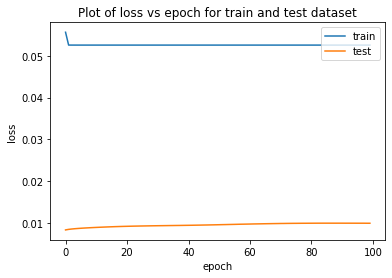

In [64]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_loss.png')
  plt.show()

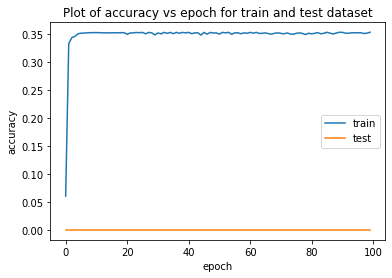

In [65]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_accuracy.png')
  plt.show()

In [66]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # representation of model layers
  plot_model(autoencoder, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary.png', show_shapes=True,)

In [67]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # calculating reconstruction error 
  predictions = autoencoder.predict(X_test)

2212/2212 [==============================] - 4s 2ms/step


In [68]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  mse = np.mean(np.power(X_test - predictions, 2), axis=1)
  error_df = pd.DataFrame({'reconstruction_error': mse,
                           'true_class': y_test})

In [69]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  error_df.describe()
  print(predictions.shape)

(70769, 78)


## **AE Classifier**

In [70]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  i_dim = predictions.shape[1]

  #input layer
  i_layer = Input(shape=(i_dim, ))
  #hidden layer with 50 neurons
  fvector = Dense(50, activation="sigmoid")(i_layer)                    
  #doutput layer
  o_layer = Dense(1, activation='sigmoid')(fvector)

In [71]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # creating model with input, encoding, decoding, output layers
  ae_classifier = Model(inputs=i_layer, outputs=o_layer)

  # defining loss function, optimizer, metrics and then compiling model
  ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [72]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # summary of model layers
  ae_classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 78)]              0         
                                                                 
 dense_5 (Dense)             (None, 50)                3950      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
_________________________________________________________________


In [73]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # training the model on training dataset
  his = ae_classifier.fit(predictions, y_test, epochs=300,batch_size=500, validation_split=0.2).history

Epoch 1/300
114/114 [==============================] - 1s 6ms/step - loss: 0.5320 - accuracy: 0.7820 - val_loss: 0.5018 - val_accuracy: 0.7990
Epoch 2/300
114/114 [==============================] - 1s 5ms/step - loss: 0.4940 - accuracy: 0.8042 - val_loss: 0.5006 - val_accuracy: 0.7990
Epoch 3/300
114/114 [==============================] - 1s 5ms/step - loss: 0.4928 - accuracy: 0.8042 - val_loss: 0.4993 - val_accuracy: 0.7990
Epoch 4/300
114/114 [==============================] - 1s 5ms/step - loss: 0.4914 - accuracy: 0.8042 - val_loss: 0.4976 - val_accuracy: 0.7990
Epoch 5/300
114/114 [==============================] - 1s 5ms/step - loss: 0.4898 - accuracy: 0.8042 - val_loss: 0.4957 - val_accuracy: 0.7990
Epoch 6/300
114/114 [==============================] - 1s 5ms/step - loss: 0.4882 - accuracy: 0.8042 - val_loss: 0.4940 - val_accuracy: 0.7990
Epoch 7/300
114/114 [==============================] - 1s 7ms/step - loss: 0.4863 - accuracy: 0.8042 - val_loss: 0.4919 - val_accuracy: 0.7990

In [74]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/ae_classifier_binary.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/ae_classifier_binary.h5'
  if (not path.isfile(filepath)): 
    # serialize model to JSON
    ae_classifier_json = ae_classifier.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(ae_classifier_json)

    # serialize weights to HDF5
    ae_classifier.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    ae_classifier = model_from_json(loaded_model_json)

    # load weights into new model
    ae_classifier.load_weights(weightspath)
    print("Loaded model from disk")

In [75]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [76]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # predicting target attribute on testing dataset
  test_results = ae_classifier.evaluate(X_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2212/2212 [==============================] - 4s 2ms/step - loss: 1.2908 - accuracy: 0.7880
Test results - Loss: 1.2907801866531372 - Accuracy: 78.7958025932312%


In [77]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # representation of model layers
  plot_model(ae_classifier, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary.png', show_shapes=True)

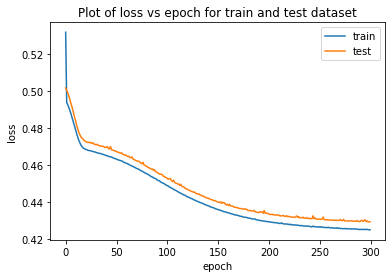

In [78]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(his['loss'])
  plt.plot(his['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary_loss.png')
  plt.show()

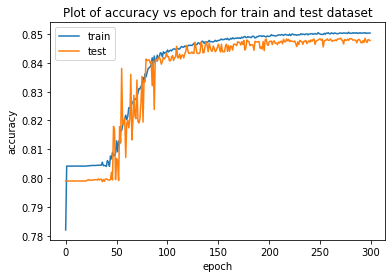

In [79]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(his['accuracy'])
  plt.plot(his['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary_accuracy.png')
  plt.show()

In [80]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  y_pred = ae_classifier.predict(X_test).ravel()
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  #auc = auc(fpr, tpr)

2212/2212 [==============================] - 5s 2ms/step


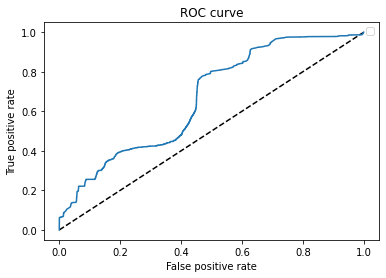

In [81]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  plt.plot([0, 1], [0, 1], 'k--')
  #plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.plot(fpr, tpr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_roc.png')
  plt.show()

In [82]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  pred = ae_classifier.predict(X_test)
  y_classes = (ae_classifier.predict(X_test)>0.5).astype('int32')

2212/2212 [==============================] - 3s 1ms/step


In [83]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))

Recall Score -  0.8894558122349878
F1 Score -  0.8707649379058511
Precision Score -  0.8528434299981443


              precision    recall  f1-score   support

           0       0.45      0.37      0.41     13932
           1       0.85      0.89      0.87     56837

    accuracy                           0.79     70769
   macro avg       0.65      0.63      0.64     70769
weighted avg       0.77      0.79      0.78     70769



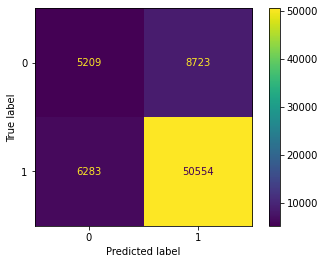

In [92]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()